In [1]:
%matplotlib inline

import os
import numpy as np
import xarray as xr
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

color_list = np.array([(255, 255, 255),  # 0.0
                       (245, 245, 255),  # 0.2
                       (180, 180, 255),  # 0.5
                       (120, 120, 255),  # 1.5
                       (20,  20, 255),   # 2.5
                       (0, 216, 195),    # 4.0
                       (0, 150, 144),    # 6.0
                       (0, 102, 102),    # 10
                       (255, 255,   0),  # 15
                       (255, 200,   0),  # 20
                       (255, 150,   0),  # 30
                       (255, 100,   0),  # 40
                       (255,   0,   0),  # 50
                       (200,   0,   0),  # 60
                       (120,   0,   0),  # 75
                       (40,   0,   0)])  # > 100

color_list = color_list/255.
bom_cm = LinearSegmentedColormap.from_list("BOM-RF3", color_list, N=32)
bom_cm.set_bad(color='gray')

In [2]:
tiles = {"VICTAS": [1130.8837, -4376.935], 
         "SYDM": [1740.4043, -3757.409], 
         "W_NSW": [935.5831, -3523.967], 
         "SA": [189.0527, -3376.863], 
         "SE_WA": [-661.3803, -3393.506], 
         "SW_WA": [-1414.6972, -3458.529], 
         "NW_WA": [-1519.7374, -2568.012], 
         "NE_WA": [-710.4872, -2498.161], 
         "N_SA": [203.0897, -2480.281], 
         "W_QLD": [1010.0804, -2574.165], 
         "SE_QLD": [1790.4011, -2828.908], 
         "NW_NT": [-704.899, -1609.515], 
         "NT": [216.9767, -1593.277], 
         "N_QLD": [867.3753, -1618.745], 
         "NE_QLD": [1597.875, -1905.570], 
         "NW_WA_COAST": [-1623.6555, -1687.006]}

tiles

{'VICTAS': [1130.8837, -4376.935],
 'SYDM': [1740.4043, -3757.409],
 'W_NSW': [935.5831, -3523.967],
 'SA': [189.0527, -3376.863],
 'SE_WA': [-661.3803, -3393.506],
 'SW_WA': [-1414.6972, -3458.529],
 'NW_WA': [-1519.7374, -2568.012],
 'NE_WA': [-710.4872, -2498.161],
 'N_SA': [203.0897, -2480.281],
 'W_QLD': [1010.0804, -2574.165],
 'SE_QLD': [1790.4011, -2828.908],
 'NW_NT': [-704.899, -1609.515],
 'NT': [216.9767, -1593.277],
 'N_QLD': [867.3753, -1618.745],
 'NE_QLD': [1597.875, -1905.57],
 'NW_WA_COAST': [-1623.6555, -1687.006]}

In [3]:
def gpm_pred(loc, d):
    
    h8_fp = "/data/pluvi_pondus/HIM8_AU_2B/HIM8_2B_AU_{}.nc".format(d.strftime("%Y%m%d"))
    h8_ds = xr.open_dataset(h8_fp)

    b8 = h8_ds.B8.sel(time=d).data[::2, ::2]
    b14 = h8_ds.B14.sel(time=d).data[::2, ::2]
    h8_ds.close()

    x = np.stack((b8,b14), axis=-1)
    
    mse = load_model('../small_z/unet_mse_gpm.h5')
    out = np.zeros((513, 613), dtype=np.float32)
    out[:-1,:-101] = mse.predict(x[None,:-1,:-201,:])[:,:,:,0]
    out[1:,101:] = mse.predict(x[None,1:,201:,:])[:,:,:,0]
    
    ds = xr.open_dataset("/data/pluvi_pondus/GPM/GPM_BoM_201811.nc")
    ds = ds.sel(time=d)
    ds = ds.drop(["albers_conical_equal_area","PrecCal"])
    ds['prec'] = (('y', 'x'), out)
    
    if loc:
        return ds.prec.sel(x=slice((loc[0]-512)*1000,(loc[0]+512)*1000),
                           y=slice((loc[1]+512)*1000,(loc[1]-512)*1000))
    else:
        return ds.prec
    
    
def gpm_predz(loc, d):
    
    dsz1000 = xr.open_dataset("/data/pluvi_pondus/ERA5/au_z1000_201811.nc")
    dsz800 = xr.open_dataset("/data/pluvi_pondus/ERA5/au_z800_201811.nc")
    dsz500 = xr.open_dataset("/data/pluvi_pondus/ERA5/au_z500_201811.nc")
    
    z500 = dsz500['z'].sel(time=d, method='nearest').values
    z800 = dsz800['z'].sel(time=d, method='nearest').values
    z1000 = dsz1000['z'].sel(time=d, method='nearest').values
    
    z = np.stack((z1000,z800,z500), axis=-1)

    
    h8_fp = "/data/pluvi_pondus/HIM8_AU_2B/HIM8_2B_AU_{}.nc".format(d.strftime("%Y%m%d"))
    h8_ds = xr.open_dataset(h8_fp)

    b8 = h8_ds.B8.sel(time=d).data[::2, ::2]
    b14 = h8_ds.B14.sel(time=d).data[::2, ::2]
    h8_ds.close()

    x = np.stack((b8,b14), axis=-1)
    
    mse = load_model('../small_z/unet_mse_gpm_z.h5')
    out = np.zeros((513, 613), dtype=np.float32)
    out[:-1,:-101] = mse.predict([x[None,:-1,:-201,:], z[None,:,:-50,:]])[:,:,:,0]
    out[1:,101:] = mse.predict([x[None,1:,201:,:], z[None,:,50:,:]])[:,:,:,0]
    
    ds = xr.open_dataset("/data/pluvi_pondus/GPM/GPM_BoM_201811.nc")
    ds = ds.sel(time=d)
    ds = ds.drop(["albers_conical_equal_area","PrecCal"])
    ds['prec'] = (('y', 'x'), out)
    
    if loc:
        return ds.prec.sel(x=slice((loc[0]-512)*1000,(loc[0]+512)*1000),
                           y=slice((loc[1]+512)*1000,(loc[1]-512)*1000))
    else:
        return ds.prec

    
def rainfields_pred(loc, d):
    
    h8_fp = "/data/pluvi_pondus/HIM8_AU_2B/HIM8_2B_AU_{}.nc".format(d.strftime("%Y%m%d"))
    h8_ds = xr.open_dataset(h8_fp)
    

    b8 = h8_ds.B8.sel(time=d).data[::2, ::2]
    b14 = h8_ds.B14.sel(time=d).data[::2, ::2]
    h8_ds.close()

    x = np.stack((b8,b14), axis=-1)
    
    mse = load_model('../small_z/unet_mse_rainfields.h5')
    
    out = np.zeros((1025,1225), dtype=np.float32)
    out[:-1,:-201] = mse.predict(x[None,:-1,:-201,:])[:,:,:,0]
    out[1:,201:] = mse.predict(x[None,1:,201:,:])[:,:,:,0]
    
    h8_ds = h8_ds.sel(time=d)
    h8_ds = h8_ds.drop(["albers_conical_equal_area","B8","B14"])
    h8_ds['y'] = h8_ds['y'].values[::2]
    h8_ds['x'] = h8_ds['x'].values[::2]
    h8_ds['prec'] = (('y', 'x'), out)
    
    if loc:
        return h8_ds.prec.sel(x=slice((loc[0]-512)*1000,(loc[0]+512)*1000),
                              y=slice((loc[1]+512)*1000,(loc[1]-512)*1000))
    else:
        return h8_ds.prec
    
def rainfields_gan_pred(loc, d):
    
    h8_fp = "/data/pluvi_pondus/HIM8_AU_2B/HIM8_2B_AU_{}.nc".format(d.strftime("%Y%m%d"))
    
    h8_ds = xr.open_dataset(h8_fp)
    
    b8 = h8_ds.B8.data[:,::2, ::2]
    b14 = h8_ds.B14.data[:,::2, ::2]
    h8_ds.close()

    x = np.stack((b8,b14), axis=-1)
    print(x.shape)
    out = np.zeros((b8.shape[0], 1025, 1225), dtype=np.float32)
    
    mse = load_model('../small_z/gan_mse_rainfields_generator.h5')
    
    for i in range(out.shape[0]):
        out[i,:-1,:-201] = mse.predict(x[i:i+1,:-1,:-201,:])[0,:,:,0]
        out[i,1:,201:] = mse.predict(x[i:i+1,1:,201:,:])[0,:,:,0]
    
    #h8_ds = h8_ds.sel(time=d)
    h8_ds = h8_ds.drop(["albers_conical_equal_area","B8","B14"])
    h8_ds['y'] = h8_ds['y'].values[::2]
    h8_ds['x'] = h8_ds['x'].values[::2]
    h8_ds['prec'] = (('time', 'y', 'x'), out)
    
    if loc:
        return h8_ds.prec.sel(x=slice((loc[0]-512)*1000,(loc[0]+512)*1000),
                              y=slice((loc[1]+512)*1000,(loc[1]-512)*1000))
    else:
        return h8_ds.prec
    

def himfields_gan_pred(loc, d): 
    himf_fp = "himfields_0106.nc"
    himf_ds = xr.open_dataset(himf_fp)
    
    if loc:
        return himf_ds.prec.sel(time=d).sel(x=slice((loc[0]-512)*1000,(loc[0]+512)*1000),
                                            y=slice((loc[1]+512)*1000,(loc[1]-512)*1000))
    else:
        return himf_ds.prec.sel(time=d)
    
    
def rainfields_predz(loc, d):
    
    dsz1000 = xr.open_dataset("/data/pluvi_pondus/ERA5/au_z1000_201811.nc")
    dsz800 = xr.open_dataset("/data/pluvi_pondus/ERA5/au_z800_201811.nc")
    dsz500 = xr.open_dataset("/data/pluvi_pondus/ERA5/au_z500_201811.nc")
    
    z500 = dsz500['z'].sel(time=d, method='nearest').values
    z800 = dsz800['z'].sel(time=d, method='nearest').values
    z1000 = dsz1000['z'].sel(time=d, method='nearest').values
    
    z = np.stack((z1000,z800,z500), axis=-1)
    
    h8_fp = "/data/pluvi_pondus/HIM8_AU_2B/HIM8_2B_AU_{}.nc".format(d.strftime("%Y%m%d"))
    h8_ds = xr.open_dataset(h8_fp)

    b8 = h8_ds.B8.sel(time=d).data[::2, ::2]
    b14 = h8_ds.B14.sel(time=d).data[::2, ::2]
    h8_ds.close()

    x = np.stack((b8,b14), axis=-1)
    
    mse = load_model('../small_z/unet_mse_rainfields_z.h5')
    
    out = np.zeros((1025,1225), dtype=np.float32)
    out[:-1,:-201] = mse.predict([x[None,:-1,:-201,:], z[None,:,:-50,:]])[:,:,:,0]
    out[1:,201:] = mse.predict([x[None,1:,201:,:], z[None,:,50:,:]])[:,:,:,0]
    
    h8_ds = h8_ds.sel(time=d)
    h8_ds = h8_ds.drop(["albers_conical_equal_area","B8","B14"])
    h8_ds['y'] = h8_ds['y'].values[::2]
    h8_ds['x'] = h8_ds['x'].values[::2]
    h8_ds['prec'] = (('y', 'x'), out)
    
    if loc:
        return h8_ds.prec.sel(x=slice((loc[0]-512)*1000,(loc[0]+512)*1000),
                              y=slice((loc[1]+512)*1000,(loc[1]-512)*1000))
    else:
        return h8_ds.prec
    
    
def rainfields_predgpm(loc, d):
    
    dsgpm = xr.open_dataset("/data/pluvi_pondus/GPM/GPM_BoM_201811.nc")
    gpm = dsgpm['PrecCal'].sel(time=d, method='nearest').values[:,:,None]
    
    h8_fp = "/data/pluvi_pondus/HIM8_AU_2B/HIM8_2B_AU_{}.nc".format(d.strftime("%Y%m%d"))
    h8_ds = xr.open_dataset(h8_fp)

    b8 = h8_ds.B8.sel(time=d).data[::2, ::2]
    b14 = h8_ds.B14.sel(time=d).data[::2, ::2]
    h8_ds.close()

    x = np.stack((b8,b14), axis=-1)
    
    mse = load_model('../small_z/unet_mse_rainfields_gpm.h5')
    
    out = np.zeros((1025,1225), dtype=np.float32)
    out[:-1,:-201] = mse.predict([x[None,:-1,:-201,:], gpm[None,:-1,:-101,:]])[:,:,:,0]
    out[1:,201:] = mse.predict([x[None,1:,201:,:], gpm[None,1:,101:,:]])[:,:,:,0]
    
    h8_ds = h8_ds.sel(time=d)
    h8_ds = h8_ds.drop(["albers_conical_equal_area","B8","B14"])
    h8_ds['y'] = h8_ds['y'].values[::2]
    h8_ds['x'] = h8_ds['x'].values[::2]
    h8_ds['prec'] = (('y', 'x'), out)
    
    if loc:
        return h8_ds.prec.sel(x=slice((loc[0]-512)*1000,(loc[0]+512)*1000),
                              y=slice((loc[1]+512)*1000,(loc[1]-512)*1000))
    else:
        return h8_ds.prec

5346.6997


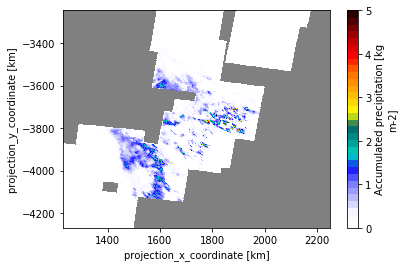

In [50]:
def rainfields(loc, date):

    ds = xr.open_dataset("/data/pluvi_pondus/Rainfields/310_{}_{}.prcp-c10.nc".format(d.strftime("%Y%m%d"),
                                                                                            d.strftime("%H%M%S")))

    if loc:
        return ds.precipitation.sel(x=slice(loc[0]-512,loc[0]+512),
                                    y=slice(loc[1]+512,loc[1]-512))
    else:
        return ds.precipitation

d = datetime(2018, 11, 7, 0, 0)

ds = rainfields(tiles["SYDM"], d)
print(np.nansum(ds.values[::2,::2]))
mask = ~np.isnan(ds.values)
ds.plot(cmap=bom_cm, vmin=0, vmax=5)

<xarray.DataArray 'prec' ()>
array(3736.5835, dtype=float32)
Coordinates:
    time     datetime64[ns] 2018-11-07


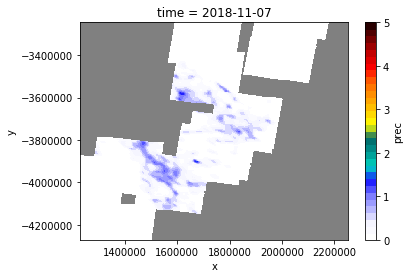

In [51]:
print(himfields_gan_pred(tiles["SYDM"], d).where(mask[::2,::2]).sum())

himfields_gan_pred(tiles["SYDM"], d).where(mask[::2,::2]).plot(cmap=bom_cm, vmin=0, vmax=5)

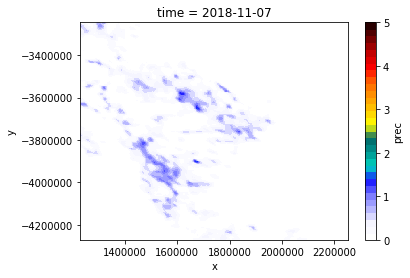

In [52]:
himfields_gan_pred(tiles["SYDM"], d).plot(cmap=bom_cm, vmin=0, vmax=5)

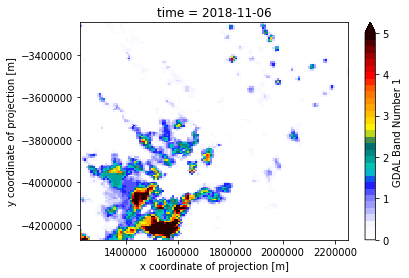

In [5]:
def gpm(loc, d):
    ds = xr.open_dataset("/data/pluvi_pondus/GPM/GPM_BoM_201811.nc")

    ds = ds.sel(time=d)
    
    if loc:
        return ds.PrecCal.sel(x=slice((loc[0]-512)*1000,(loc[0]+512)*1000),
                              y=slice((loc[1]+512)*1000,(loc[1]-512)*1000))
    else:
        return ds.PrecCal

ds = gpm(tiles["SYDM"], d)
ds.plot(cmap=bom_cm, vmin=0, vmax=5)

In [59]:
def crr(loc, date):
    fname = "/data/pluvi_pondus/Himawari-CRR/{}{}-P1S-ABOM_CRR-PRJ_AEA132_2000-HIMAWARI8-AHI.nc".format(d.strftime("%Y%m%d"), d.strftime("%H%M%S"))
    
    if not os.path.isfile(fname):
        return np.zeros((8,8), dtype=np.float32)
    
    ds = xr.open_dataset(fname)
    ds = ds.isel(time=0)
    
    if loc:
        return ds.precipitation_flux.sel(x=slice((loc[0]-512)*1000,(loc[0]+512)*1000),
                                         y=slice((loc[1]+512)*1000,(loc[1]-512)*1000))
    else:
        return ds.precipitation_flux

ds = crr(tiles["SYDM"], d)
ds.plot(cmap=bom_cm, vmin=0, vmax=5)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
ds = gpm_pred(tiles["SYDM"], d)
ds.plot(cmap=bom_cm, vmin=0, vmax=5)

In [ ]:
ds = gpm_predz(tiles["SYDM"], d)
ds.plot(cmap=bom_cm, vmin=0, vmax=5)

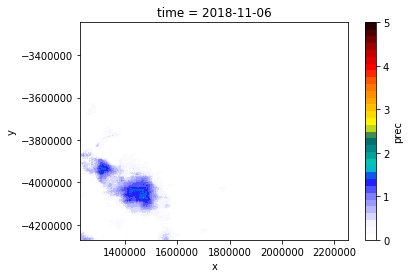

In [8]:
ds = rainfields_pred(tiles["SYDM"], d)
ds.plot(cmap=bom_cm, vmin=0, vmax=5)

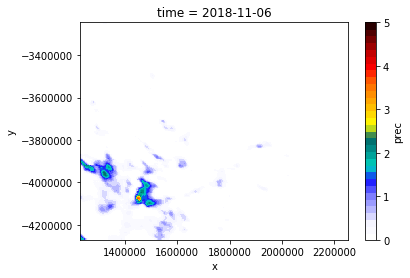

In [9]:
ds = rainfields_gan_pred(tiles["SYDM"], d)
ds.plot(cmap=bom_cm, vmin=0, vmax=5)

In [ ]:
ds = rainfields_predz(tiles["SYDM"], d)
ds.plot(cmap=bom_cm, vmin=0, vmax=5)

In [ ]:
ds = rainfields_predgpm(tiles["SYDM"], d)
ds.plot(cmap=bom_cm, vmin=0, vmax=5)

In [ ]:
def mse_m1(loc, d):
    
    da = rainfields(loc, d)
    new_lon = np.linspace(da.x[0], da.x[-1], len(da.x.values) * .5)
    new_lat = np.linspace(da.y[0], da.y[-1], len(da.y.values) * .5)
    tar = da.interp(y=new_lat, x=new_lon)
    
    pred = rainfields_pred(loc, d)
    
    return np.nanmean(np.square(pred.values-tar.values))

def pod_m1(loc, d, threshold):
    
    da = rainfields(loc, d)
    new_lon = np.linspace(da.x[0], da.x[-1], len(da.x.values) * .5)
    new_lat = np.linspace(da.y[0], da.y[-1], len(da.y.values) * .5)
    tar = da.interp(y=new_lat, x=new_lon).values
    
    pred = rainfields_pred(loc, d).values
    
    mask = np.isnan(tar)
    
    hits = np.nansum(np.logical_and(tar[~mask]>threshold, pred[~mask]>threshold))
    misses = np.nansum(np.logical_and(tar[~mask]>threshold, pred[~mask]<threshold))
    
    return hits / (hits + misses)
    
    
def mse_m2(loc, d):
    
    da = rainfields(loc, d)
    new_lon = np.linspace(da.x[0], da.x[-1], len(da.x.values) * .5)
    new_lat = np.linspace(da.y[0], da.y[-1], len(da.y.values) * .5)
    tar = da.interp(y=new_lat, x=new_lon)
    
    pred = rainfields_predgpm(loc, d)
    
    return np.nanmean(np.square(pred.values-tar.values))


def pod_m2(loc, d, threshold):
    
    da = rainfields(loc, d)
    new_lon = np.linspace(da.x[0], da.x[-1], len(da.x.values) * .5)
    new_lat = np.linspace(da.y[0], da.y[-1], len(da.y.values) * .5)
    tar = da.interp(y=new_lat, x=new_lon).values
    
    pred = rainfields_predgpm(loc, d).values
    
    mask = np.isnan(tar)
    
    plt.imshow(mask)
    
    print(pred.shape, pred[~mask].shape, tar[~mask].shape, np.count_nonzero(pred[~mask]>1.), np.count_nonzero(tar[~mask]>1.))

    
    hits = np.nansum(np.logical_and(tar[~mask]>threshold, pred[~mask]>threshold))
    misses = np.nansum(np.logical_and(tar[~mask]>threshold, pred[~mask]<threshold))
    
    if hits+misses == 0:
        return 0
    
    else:
        return hits / (hits + misses)




def mse_crr(loc, d):
    
    da = rainfields(loc, d)
    new_lon = np.linspace(da.x[0], da.x[-1], len(da.x.values) * .5)
    new_lat = np.linspace(da.y[0], da.y[-1], len(da.y.values) * .5)
    tar = da.interp(y=new_lat, x=new_lon)
    
    da = crr(loc, d)
    new_lon = np.linspace(da.x[0], da.x[-1], len(da.x.values) * .5)
    new_lat = np.linspace(da.y[0], da.y[-1], len(da.y.values) * .5)
    pred = da.interp(y=new_lat, x=new_lon)
    
    return np.nanmean(np.square(pred.values-tar.values))


def mse_zero(loc, d):
    
    da = rainfields(loc, d)
    new_lon = np.linspace(da.x[0], da.x[-1], len(da.x.values) * .5)
    new_lat = np.linspace(da.y[0], da.y[-1], len(da.y.values) * .5)
    tar = da.interp(y=new_lat, x=new_lon)
    
    pred = np.zeros(tar.values.shape,dtype=np.float32)
    
    return np.nanmean(np.square(pred-tar.values))


In [ ]:
pod_m2(loc, d, 1.)

In [ ]:
loc = tiles["SYDM"]
base = datetime(2018, 11, 1, 0, 0)
res = []
res_pod = []
for i, d in enumerate([base + timedelta(days=x) for x in range(15)]):
    #res.append([mse_m1(loc, d), mse_m2(loc, d), mse_crr(loc, d), mse_zero(loc, d)])
    res_pod.append([pod_m1(loc, d, 1.), pod_m2(loc, d, 1.)])

In [ ]:
res_arr = np.array(res)
plt.plot(res_arr[:,[0,1,3]])
plt.gca().legend(('pred','pred2','zeros'))

In [ ]:
res_arr = np.array(res_pod)
plt.plot(res_arr)
plt.gca().legend(('pred','crr','zeros'))

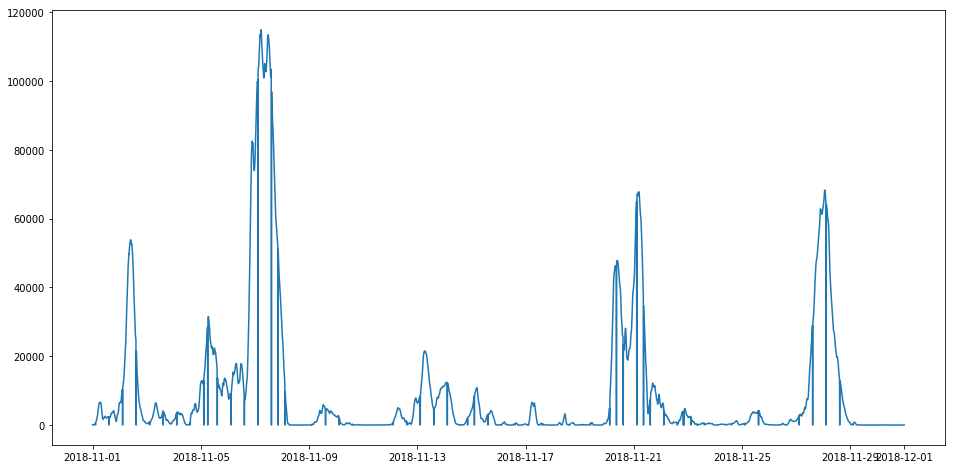

In [60]:
import seaborn as sns

loc = tiles["SYDM"]
base = datetime(2018, 11, 1, 0, 0)

prec = []
time = [base + timedelta(seconds=x*10*60) for x in range(6*24*30)]

for i, d in enumerate(time):
    prec.append(np.nansum(crr(tiles["SYDM"], d)[::2,::2]))

prec_arr = np.array(prec)
plt.figure(figsize=(16,8))
plt.plot(time, prec_arr)

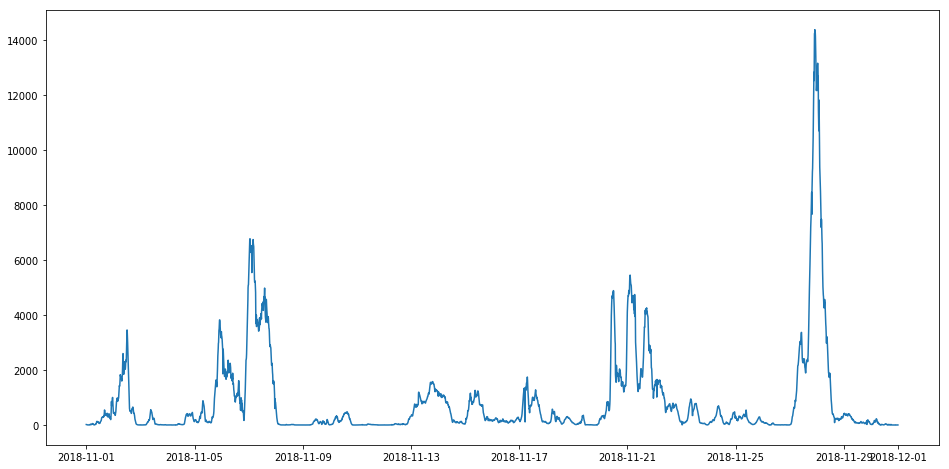

In [29]:
prec = []

for i, d in enumerate(time):
    prec.append(np.nansum(rainfields(tiles["SYDM"], d)[::2,::2]))

prec_arr = np.array(prec)
plt.figure(figsize=(16,8))
plt.plot(time, prec_arr)

(4320, 2)
                    total_prec
date                          
2018-11-01 00:00:00       76.6
2018-11-01 00:10:00      61.75
2018-11-01 00:20:00       54.3
2018-11-01 00:30:00      52.35
2018-11-01 00:40:00       44.2
...                        ...
2018-11-30 23:10:00      11.15
2018-11-30 23:20:00        9.9
2018-11-30 23:30:00       12.7
2018-11-30 23:40:00      12.75
2018-11-30 23:50:00        9.2

[4320 rows x 1 columns]


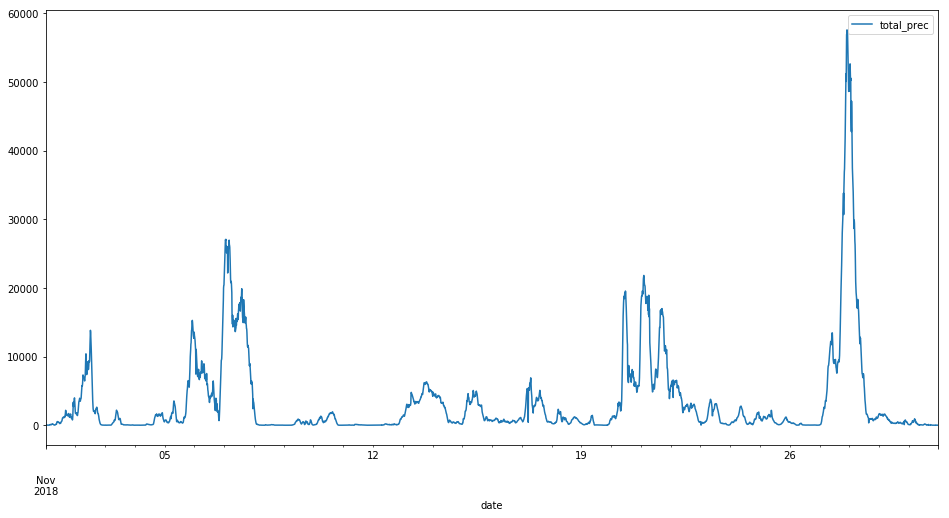

In [101]:
import pandas as pd

data = np.stack((np.array(time),prec_arr), axis=1)

print(data.shape)


df = pd.DataFrame(data, columns=["date","total_prec"])
df = df.set_index('date')
print(df)

"""



chart = sns.lineplot(
    data=df,
    y='total_prec'
)
#chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

"""

df.plot(figsize=(16,8))

In [52]:
gan_prec = []

for i, d in enumerate(time):
    gan_prec.append(rainfields_gan_pred(tiles["SYDM"], d).sum())

gan_prec_arr = np.array(gan_prec)

<xarray.DataArray 'time' (time: 142)>
array(['2018-11-01T00:00:00.000000000', '2018-11-01T00:10:00.000000000',
       '2018-11-01T00:20:00.000000000', '2018-11-01T00:30:00.000000000',
       '2018-11-01T00:40:00.000000000', '2018-11-01T00:50:00.000000000',
       '2018-11-01T01:00:00.000000000', '2018-11-01T01:10:00.000000000',
       '2018-11-01T01:20:00.000000000', '2018-11-01T01:30:00.000000000',
       '2018-11-01T01:40:00.000000000', '2018-11-01T01:50:00.000000000',
       '2018-11-01T02:00:00.000000000', '2018-11-01T02:10:00.000000000',
       '2018-11-01T02:20:00.000000000', '2018-11-01T02:30:00.000000000',
       '2018-11-01T02:50:00.000000000', '2018-11-01T03:00:00.000000000',
       '2018-11-01T03:10:00.000000000', '2018-11-01T03:20:00.000000000',
       '2018-11-01T03:30:00.000000000', '2018-11-01T03:40:00.000000000',
       '2018-11-01T03:50:00.000000000', '2018-11-01T04:00:00.000000000',
       '2018-11-01T04:10:00.000000000', '2018-11-01T04:20:00.000000000',
       '2018-

<xarray.DataArray 'time' (time: 142)>
array(['2018-11-01T00:00:00.000000000', '2018-11-01T00:10:00.000000000',
       '2018-11-01T00:20:00.000000000', '2018-11-01T00:30:00.000000000',
       '2018-11-01T00:40:00.000000000', '2018-11-01T00:50:00.000000000',
       '2018-11-01T01:00:00.000000000', '2018-11-01T01:10:00.000000000',
       '2018-11-01T01:20:00.000000000', '2018-11-01T01:30:00.000000000',
       '2018-11-01T01:40:00.000000000', '2018-11-01T01:50:00.000000000',
       '2018-11-01T02:00:00.000000000', '2018-11-01T02:10:00.000000000',
       '2018-11-01T02:20:00.000000000', '2018-11-01T02:30:00.000000000',
       '2018-11-01T02:50:00.000000000', '2018-11-01T03:00:00.000000000',
       '2018-11-01T03:10:00.000000000', '2018-11-01T03:20:00.000000000',
       '2018-11-01T03:30:00.000000000', '2018-11-01T03:40:00.000000000',
       '2018-11-01T03:50:00.000000000', '2018-11-01T04:00:00.000000000',
       '2018-11-01T04:10:00.000000000', '2018-11-01T04:20:00.000000000',
       '2018-

<xarray.DataArray 'time' (time: 142)>
array(['2018-11-01T00:00:00.000000000', '2018-11-01T00:10:00.000000000',
       '2018-11-01T00:20:00.000000000', '2018-11-01T00:30:00.000000000',
       '2018-11-01T00:40:00.000000000', '2018-11-01T00:50:00.000000000',
       '2018-11-01T01:00:00.000000000', '2018-11-01T01:10:00.000000000',
       '2018-11-01T01:20:00.000000000', '2018-11-01T01:30:00.000000000',
       '2018-11-01T01:40:00.000000000', '2018-11-01T01:50:00.000000000',
       '2018-11-01T02:00:00.000000000', '2018-11-01T02:10:00.000000000',
       '2018-11-01T02:20:00.000000000', '2018-11-01T02:30:00.000000000',
       '2018-11-01T02:50:00.000000000', '2018-11-01T03:00:00.000000000',
       '2018-11-01T03:10:00.000000000', '2018-11-01T03:20:00.000000000',
       '2018-11-01T03:30:00.000000000', '2018-11-01T03:40:00.000000000',
       '2018-11-01T03:50:00.000000000', '2018-11-01T04:00:00.000000000',
       '2018-11-01T04:10:00.000000000', '2018-11-01T04:20:00.000000000',
       '2018-

<xarray.DataArray 'time' (time: 142)>
array(['2018-11-01T00:00:00.000000000', '2018-11-01T00:10:00.000000000',
       '2018-11-01T00:20:00.000000000', '2018-11-01T00:30:00.000000000',
       '2018-11-01T00:40:00.000000000', '2018-11-01T00:50:00.000000000',
       '2018-11-01T01:00:00.000000000', '2018-11-01T01:10:00.000000000',
       '2018-11-01T01:20:00.000000000', '2018-11-01T01:30:00.000000000',
       '2018-11-01T01:40:00.000000000', '2018-11-01T01:50:00.000000000',
       '2018-11-01T02:00:00.000000000', '2018-11-01T02:10:00.000000000',
       '2018-11-01T02:20:00.000000000', '2018-11-01T02:30:00.000000000',
       '2018-11-01T02:50:00.000000000', '2018-11-01T03:00:00.000000000',
       '2018-11-01T03:10:00.000000000', '2018-11-01T03:20:00.000000000',
       '2018-11-01T03:30:00.000000000', '2018-11-01T03:40:00.000000000',
       '2018-11-01T03:50:00.000000000', '2018-11-01T04:00:00.000000000',
       '2018-11-01T04:10:00.000000000', '2018-11-01T04:20:00.000000000',
       '2018-

<xarray.DataArray 'time' (time: 142)>
array(['2018-11-01T00:00:00.000000000', '2018-11-01T00:10:00.000000000',
       '2018-11-01T00:20:00.000000000', '2018-11-01T00:30:00.000000000',
       '2018-11-01T00:40:00.000000000', '2018-11-01T00:50:00.000000000',
       '2018-11-01T01:00:00.000000000', '2018-11-01T01:10:00.000000000',
       '2018-11-01T01:20:00.000000000', '2018-11-01T01:30:00.000000000',
       '2018-11-01T01:40:00.000000000', '2018-11-01T01:50:00.000000000',
       '2018-11-01T02:00:00.000000000', '2018-11-01T02:10:00.000000000',
       '2018-11-01T02:20:00.000000000', '2018-11-01T02:30:00.000000000',
       '2018-11-01T02:50:00.000000000', '2018-11-01T03:00:00.000000000',
       '2018-11-01T03:10:00.000000000', '2018-11-01T03:20:00.000000000',
       '2018-11-01T03:30:00.000000000', '2018-11-01T03:40:00.000000000',
       '2018-11-01T03:50:00.000000000', '2018-11-01T04:00:00.000000000',
       '2018-11-01T04:10:00.000000000', '2018-11-01T04:20:00.000000000',
       '2018-

<xarray.DataArray 'time' (time: 142)>
array(['2018-11-01T00:00:00.000000000', '2018-11-01T00:10:00.000000000',
       '2018-11-01T00:20:00.000000000', '2018-11-01T00:30:00.000000000',
       '2018-11-01T00:40:00.000000000', '2018-11-01T00:50:00.000000000',
       '2018-11-01T01:00:00.000000000', '2018-11-01T01:10:00.000000000',
       '2018-11-01T01:20:00.000000000', '2018-11-01T01:30:00.000000000',
       '2018-11-01T01:40:00.000000000', '2018-11-01T01:50:00.000000000',
       '2018-11-01T02:00:00.000000000', '2018-11-01T02:10:00.000000000',
       '2018-11-01T02:20:00.000000000', '2018-11-01T02:30:00.000000000',
       '2018-11-01T02:50:00.000000000', '2018-11-01T03:00:00.000000000',
       '2018-11-01T03:10:00.000000000', '2018-11-01T03:20:00.000000000',
       '2018-11-01T03:30:00.000000000', '2018-11-01T03:40:00.000000000',
       '2018-11-01T03:50:00.000000000', '2018-11-01T04:00:00.000000000',
       '2018-11-01T04:10:00.000000000', '2018-11-01T04:20:00.000000000',
       '2018-

<xarray.DataArray 'time' (time: 142)>
array(['2018-11-01T00:00:00.000000000', '2018-11-01T00:10:00.000000000',
       '2018-11-01T00:20:00.000000000', '2018-11-01T00:30:00.000000000',
       '2018-11-01T00:40:00.000000000', '2018-11-01T00:50:00.000000000',
       '2018-11-01T01:00:00.000000000', '2018-11-01T01:10:00.000000000',
       '2018-11-01T01:20:00.000000000', '2018-11-01T01:30:00.000000000',
       '2018-11-01T01:40:00.000000000', '2018-11-01T01:50:00.000000000',
       '2018-11-01T02:00:00.000000000', '2018-11-01T02:10:00.000000000',
       '2018-11-01T02:20:00.000000000', '2018-11-01T02:30:00.000000000',
       '2018-11-01T02:50:00.000000000', '2018-11-01T03:00:00.000000000',
       '2018-11-01T03:10:00.000000000', '2018-11-01T03:20:00.000000000',
       '2018-11-01T03:30:00.000000000', '2018-11-01T03:40:00.000000000',
       '2018-11-01T03:50:00.000000000', '2018-11-01T04:00:00.000000000',
       '2018-11-01T04:10:00.000000000', '2018-11-01T04:20:00.000000000',
       '2018-

<xarray.DataArray 'time' (time: 142)>
array(['2018-11-01T00:00:00.000000000', '2018-11-01T00:10:00.000000000',
       '2018-11-01T00:20:00.000000000', '2018-11-01T00:30:00.000000000',
       '2018-11-01T00:40:00.000000000', '2018-11-01T00:50:00.000000000',
       '2018-11-01T01:00:00.000000000', '2018-11-01T01:10:00.000000000',
       '2018-11-01T01:20:00.000000000', '2018-11-01T01:30:00.000000000',
       '2018-11-01T01:40:00.000000000', '2018-11-01T01:50:00.000000000',
       '2018-11-01T02:00:00.000000000', '2018-11-01T02:10:00.000000000',
       '2018-11-01T02:20:00.000000000', '2018-11-01T02:30:00.000000000',
       '2018-11-01T02:50:00.000000000', '2018-11-01T03:00:00.000000000',
       '2018-11-01T03:10:00.000000000', '2018-11-01T03:20:00.000000000',
       '2018-11-01T03:30:00.000000000', '2018-11-01T03:40:00.000000000',
       '2018-11-01T03:50:00.000000000', '2018-11-01T04:00:00.000000000',
       '2018-11-01T04:10:00.000000000', '2018-11-01T04:20:00.000000000',
       '2018-

<xarray.DataArray 'time' (time: 142)>
array(['2018-11-01T00:00:00.000000000', '2018-11-01T00:10:00.000000000',
       '2018-11-01T00:20:00.000000000', '2018-11-01T00:30:00.000000000',
       '2018-11-01T00:40:00.000000000', '2018-11-01T00:50:00.000000000',
       '2018-11-01T01:00:00.000000000', '2018-11-01T01:10:00.000000000',
       '2018-11-01T01:20:00.000000000', '2018-11-01T01:30:00.000000000',
       '2018-11-01T01:40:00.000000000', '2018-11-01T01:50:00.000000000',
       '2018-11-01T02:00:00.000000000', '2018-11-01T02:10:00.000000000',
       '2018-11-01T02:20:00.000000000', '2018-11-01T02:30:00.000000000',
       '2018-11-01T02:50:00.000000000', '2018-11-01T03:00:00.000000000',
       '2018-11-01T03:10:00.000000000', '2018-11-01T03:20:00.000000000',
       '2018-11-01T03:30:00.000000000', '2018-11-01T03:40:00.000000000',
       '2018-11-01T03:50:00.000000000', '2018-11-01T04:00:00.000000000',
       '2018-11-01T04:10:00.000000000', '2018-11-01T04:20:00.000000000',
       '2018-

KeyError: Timestamp('2018-11-01 02:40:00')

In [72]:
stack = None

for i in range(30):
    d = datetime(2018, 11, i+1, 0, 0)
    out = rainfields_gan_pred(tiles["SYDM"], d)
    if stack is None:
        stack = out
    else:
        stack = np.concatenate((stack,out), axis=0)
        
    print(stack.shape)
    

(142, 1025, 1225, 2)
(142, 256, 256)
(142, 1025, 1225, 2)
(284, 256, 256)
(142, 1025, 1225, 2)
(426, 256, 256)
(142, 1025, 1225, 2)
(568, 256, 256)
(141, 1025, 1225, 2)
(709, 256, 256)
(142, 1025, 1225, 2)
(851, 256, 256)
(141, 1025, 1225, 2)
(992, 256, 256)
(139, 1025, 1225, 2)
(1131, 256, 256)
(142, 1025, 1225, 2)
(1273, 256, 256)
(142, 1025, 1225, 2)
(1415, 256, 256)
(142, 1025, 1225, 2)
(1557, 256, 256)
(142, 1025, 1225, 2)
(1699, 256, 256)
(142, 1025, 1225, 2)
(1841, 256, 256)
(141, 1025, 1225, 2)
(1982, 256, 256)
(142, 1025, 1225, 2)
(2124, 256, 256)
(142, 1025, 1225, 2)
(2266, 256, 256)
(141, 1025, 1225, 2)
(2407, 256, 256)
(140, 1025, 1225, 2)
(2547, 256, 256)
(140, 1025, 1225, 2)
(2687, 256, 256)
(142, 1025, 1225, 2)
(2829, 256, 256)
(142, 1025, 1225, 2)
(2971, 256, 256)
(140, 1025, 1225, 2)
(3111, 256, 256)
(141, 1025, 1225, 2)
(3252, 256, 256)
(142, 1025, 1225, 2)
(3394, 256, 256)
(142, 1025, 1225, 2)
(3536, 256, 256)
(142, 1025, 1225, 2)
(3678, 256, 256)
(142, 1025, 1225, 2

In [74]:
tstack = None

for i in range(30):
    d = datetime(2018, 11, i+1, 0, 0)
    h8_fp = "/data/pluvi_pondus/HIM8_AU_2B/HIM8_2B_AU_{}.nc".format(d.strftime("%Y%m%d"))
    h8_ds = xr.open_dataset(h8_fp)
    
    if tstack is None:
        tstack = h8_ds.time.values
    else:
        tstack = np.concatenate((tstack, h8_ds.time.values), axis=0)
        
    print(tstack.shape)

(142,)
(284,)
(426,)
(568,)
(709,)
(851,)
(992,)
(1131,)
(1273,)
(1415,)
(1557,)
(1699,)
(1841,)
(1982,)
(2124,)
(2266,)
(2407,)
(2547,)
(2687,)
(2829,)
(2971,)
(3111,)
(3252,)
(3394,)
(3536,)
(3678,)
(3820,)
(3962,)
(4103,)
(4245,)


In [83]:
dstack = [datetime.utcfromtimestamp(tstack[i].astype(int) * 1e-9) for i in range(tstack.shape[0])]

In [93]:
np.repeat(mask[None,:,:], 10, axis=0).shape, mask.dtype

((10, 512, 512), dtype('bool'))

(4245, 2)
                    total_prec
date                          
2018-11-01 00:00:00          0
2018-11-01 00:10:00          0
2018-11-01 00:20:00          0
2018-11-01 00:30:00          0
2018-11-01 00:40:00          0
...                        ...
2018-11-30 23:10:00   0.741292
2018-11-30 23:20:00   0.246337
2018-11-30 23:30:00          0
2018-11-30 23:40:00    0.22556
2018-11-30 23:50:00  0.0136833

[4245 rows x 1 columns]


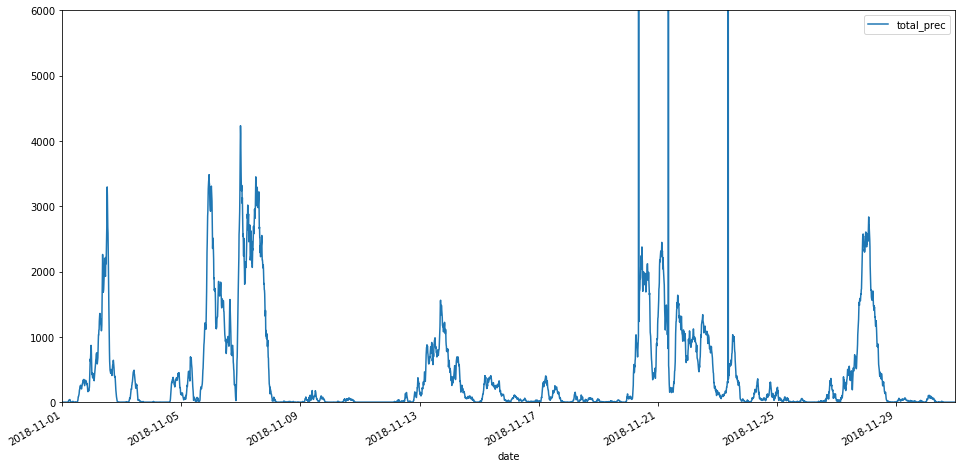

In [102]:
mstack = np.where(np.repeat(mask[None,::2,::2], stack.shape[0], axis=0), stack, np.zeros(stack.shape))


data = np.stack((np.array(dstack), mstack.sum(axis=(1,2))), axis=1)

print(data.shape)


df = pd.DataFrame(data, columns=["date","total_prec"])
df = df.set_index('date')
print(df)


"""


chart = sns.lineplot(
    data=df,
    y='total_prec'
)
#chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

"""

df.plot(figsize=(16,8), ylim=(0,6000))

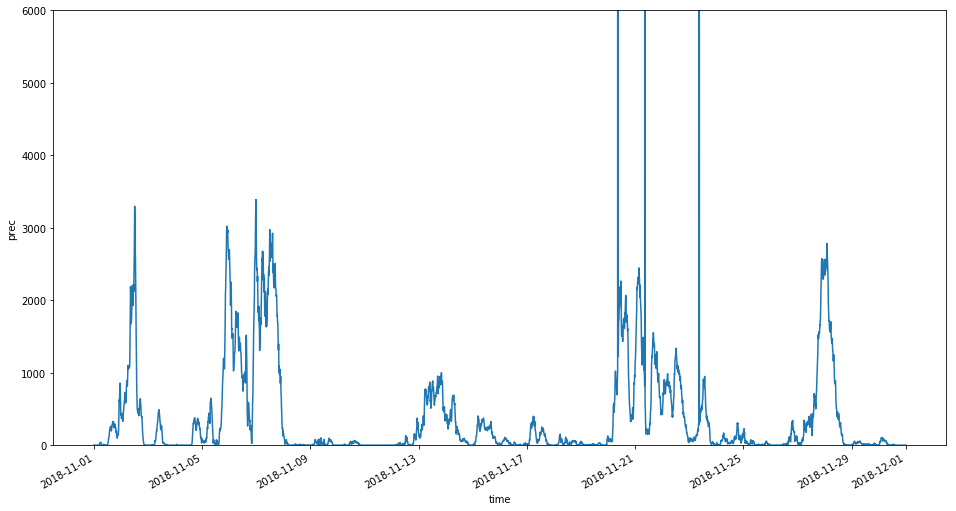

In [19]:
loc=tiles["SYDM"]

himf_fp = "himfields_0106.nc"
himf_ds = xr.open_dataset(himf_fp)
himf_ds.prec.sel(x=slice((loc[0]-512)*1000,(loc[0]+512)*1000),
                 y=slice((loc[1]+512)*1000,(loc[1]-512)*1000)).where(np.repeat(mask[None,::2,::2], himf_ds.time.shape[0], axis=0)).sum(axis=(1,2)).plot(figsize=(16,8), ylim=(0,6000))

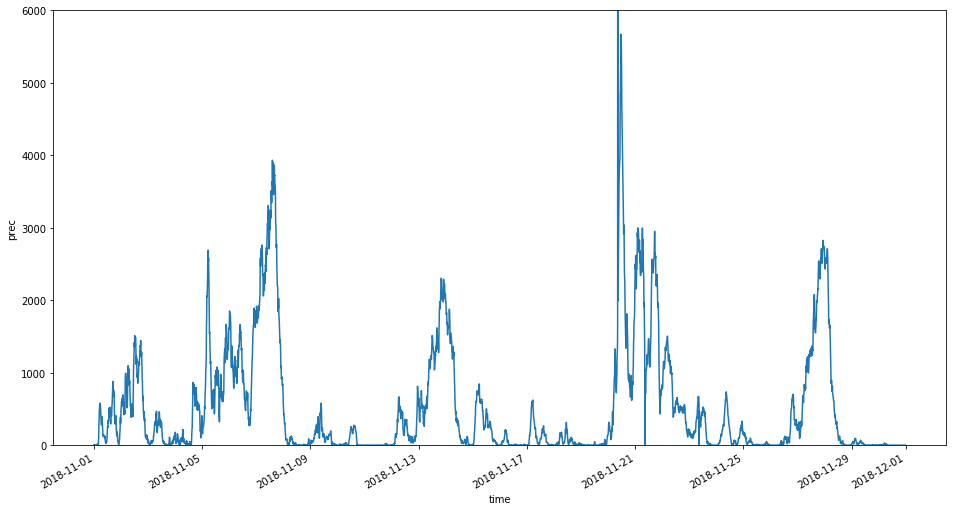

In [61]:
himf_fp = "himfields_1924.nc"
himf_ds = xr.open_dataset(himf_fp)
himf_ds.prec.sel(x=slice((loc[0]-512)*1000,(loc[0]+512)*1000),
                 y=slice((loc[1]+512)*1000,(loc[1]-512)*1000)).where(np.repeat(mask[None,::2,::2], himf_ds.time.shape[0], axis=0)).sum(axis=(1,2)).plot(figsize=(16,8), ylim=(0,6000))